# Food Intake Study - FED-3 Analysis Code

### Written by Brandon Wu

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit

### Import Mice Organizational File as Dataframe (Cage, Mice #, Cohort, Weight, etc.)

In [18]:
# Load master dataframe
data = pd.read_csv('Food Intake Study Mice Data.csv')

# Remove acclimation columns and delete unused mice
data = data[['Cage #', 'Tag #', 'Mouse #', 'Cohort #', 'Tail Marks', 'DOB', 'Age at Study Start (w)',
             'Initial Weight (g)']]

# Re-merge cage numbers
data['Cage #'] = data['Cage #'].fillna(method='ffill')

# Split cohort and number into two columns (i.e. 3 (#2) -> 3 2 in separate columns)
data['Cohort'] = data['Cohort #']
data[['Cohort', 'Cohort #']] = data.Cohort.str.split(' ', expand=True)
for char in ['(', ')', "#"]:
    data['Cohort #'] = data['Cohort #'].str.replace(char, '')
data = data[['Cage #', 'Tag #', 'Mouse #', 'Cohort', 'Cohort #', 'Tail Marks', 
            'DOB', 'Age at Study Start (w)', 'Initial Weight (g)']]

# Remove error values
data = data[data['Age at Study Start (w)'] != '#VALUE!']

# Convert all necessary columns into floats
numeric_columns = ['Cage #', 'Tag #', 'Mouse #', 'Tail Marks', 'Age at Study Start (w)',
                   'Initial Weight (g)']
for column in numeric_columns:
    data[column] = pd.to_numeric(data[column], downcast="float")

master_df = data[['Cage #', 'Mouse #', 'Tag #', 'Cohort', 'Cohort #', 'Initial Weight (g)']]
master_df = master_df.dropna()
master_df.to_csv('Mouse Cage+Tag+Cohort.csv')
master_df.head()

C:\Users\brand\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,5,6,8,9,10,11,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-18-c4c02bcd7074>:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['Cohort #'] = data['Cohort #'].str.replace(char, '')


,Cage #,Mouse #,Tag #,Cohort,Cohort #,Initial Weight (g)
5,3.0,1.0,87134.0,1,1,30.450001
6,3.0,2.0,87136.0,1,2,30.250000
7,4.0,3.0,87135.0,2,1,30.690001
8,4.0,4.0,87137.0,2,2,28.250000
10,5.0,5.0,87188.0,1,3,31.930000


### Define Processing Functions

In [19]:
def load_data(filename):
    '''
    Returns a cleaned pandas dataframe from the specified
    file pathway.
    '''
    data = pd.read_csv(filename)
    data = data.fillna(0)
    # data = data[data['Event'] == 'Pellet']
    return data


def process_data(data, time_to_pellet):
    '''
    Returns a dataframe of two columns consisting of number of
    pellets eaten and cumulative time.
    '''
    intervals = data['InterPelletInterval']
    cumulative = []
    for i in range(len(intervals)):
        if i == 0:
            cumulative.append(0)
        else:
            cumulative.append(cumulative[i-1] + intervals[i])
    data['CumulativePelletInterval'] = cumulative

    # Filter dataframe and renumber index
    new_data = data[['Pellet_Count', 'CumulativePelletInterval']]
    new_data = new_data[new_data['Pellet_Count'] > 0]
    new_data = new_data[new_data['CumulativePelletInterval'] <= 7200]
    new_data = new_data.reset_index(drop=True)
    # new_data = new_data.drop(columns=['index'])

    # Add time until first pellet and set max values at 0 and 7200 seconds
    new_data['CumulativePelletInterval'] = new_data['CumulativePelletInterval'] + time_to_pellet
    new_data.loc[-1] = [0, 0]
    new_data.index = new_data.index + 1
    new_data.sort_index(inplace=True)
    new_data.loc[-1] = [new_data.iloc[-1, 0], 7200] 
    new_data = new_data.reset_index(drop=True)
    # new_data = new_data.drop(columns=['index'])

    # Convert to minutes
    new_data['CumulativePelletInterval'] = new_data['CumulativePelletInterval'] / 60
    # print('Total pellets: ' + str(new_data['Pellet_Count'].max()))
    return new_data


def process_data_minus_pellet(data):
    '''
    Returns a dataframe of two columns consisting of number of
    pellets eaten and cumulative time. This function assumes that a
    pellet was taken at the start of the FED-3 recording.
    '''
    intervals = data['InterPelletInterval']
    cumulative = []
    for i in range(len(intervals)):
        if i == 0:
            cumulative.append(0)
        else:
            cumulative.append(cumulative[i-1] + intervals[i])
    data['CumulativePelletInterval'] = cumulative

    # Add point at end that has max time
    new_data = data[['Pellet_Count', 'CumulativePelletInterval']]
    new_data = new_data[new_data['Pellet_Count'] > 0]
    new_data = new_data[new_data['CumulativePelletInterval'] <= 7200]

    # Remove the one pellet taken to mark the start
    new_data['Pellet_Count'] = new_data.loc[:, 'Pellet_Count'] - 1 

    # Add point at start and end
    new_data.loc[-1] = [0, 0]
    new_data.index = new_data.index + 1
    new_data.sort_index(inplace=True)
    new_data.loc[-1] = [new_data.iloc[-1, 0], 7200] 
    new_data = new_data.reset_index(drop=True)
    # new_data = new_data.drop(columns=['index'])

    # Convert to minutes
    new_data['CumulativePelletInterval'] = new_data['CumulativePelletInterval'] / 60
    # print('Total pellets: ' + str(new_data['Pellet_Count'].max()))
    return new_data


def get_total(data):
    '''
    Returns the total number of pellets eaten by each mouse
    '''
    return data['Pellet_Count'].max()


def plot_data(data, mouse_num):
    '''
    Plots and saves a regression plot of the provided dataframe and
    mouse number
    '''
    fig, ax = plt.subplots(1, 1)
    sns.set()
    sns.lineplot(data=data, x='CumulativePelletInterval', y='Pellet_Count',
                 ax=ax, drawstyle='steps-post')
    ax.set_title('Food Intake over Time | Mouse ' + str(mouse_num))
    ax.set_xlabel('Time (mins)')
    ax.set_ylabel('Total Pellets Eaten')
    plt.savefig('Food Intake Study Data/plots/Individual Mice Plots/Intake Data Mouse # ' +
                str(mouse_num) + '.png', 
                bbox_inches='tight')
    # plt.show()
    plt.close()

### Define study data files and process/save individual mice plots

In [20]:
# List filenames in dicitonary with values equal to [Mouse #, Cohort, time until first pellet eaten, uneaten pellets]
filenames_to_mouse = {
    'Food Intake Study Data/080522 Mouse 87197.CSV':[10, 3, 340, 0],
    'Food Intake Study Data/080522 Mouse 87198.CSV':[11, 3, 1899, 0],
    'Food Intake Study Data/080522 Mouse 87200.CSV':[12, 3, 190, 1],
    'Food Intake Study Data/080522 Mouse 87201.CSV':[13, 3, 191, 0]
}

# List filenames in dicitonary with values equal to [Mouse #, Cohort, uneaten pellets]
filenames_to_mouse_minus_pellet = {
    # 'Food Intake Study Data/080822 Mouse 87395.CSV':[15, 3, 9],
    'Food Intake Study Data/080822 Mouse 87396.CSV':[16, 3, 0],
    'Food Intake Study Data/080822 Mouse 87191.CSV':[9, 3, 0],
    'Food Intake Study Data/080822 Mouse 87394.CSV':[14, 3, 0],
    # 'Food Intake Study Data/081022 Mouse 87135.CSV':[3, 2, 14],
    # 'Food Intake Study Data/081022 Mouse 87137.CSV':[4, 2, 7],
    'Food Intake Study Data/081222 Mouse 87134.CSV':[1, 1, 0],
    'Food Intake Study Data/081522 Mouse 87136.CSV':[2, 1, 0],
    # 'Food Intake Study Data/081622 Mouse 87188.CSV':[5, 1, 10], # NOTE: Check uneaten pellets with Asmit
    'Food Intake Study Data/081622 Mouse 87189.CSV':[6, 1, 1],
    'Food Intake Study Data/081722 Mouse 87399.CSV':[21, 4, 1],
    'Food Intake Study Data/081722 Mouse 87501.CSV':[22, 4, 0],
    'Food Intake Study Data/081722 Mouse 87503.CSV':[23, 4, 0],
    'Food Intake Study Data/081722 Mouse 87588.CSV':[28, 4, 0],
    'Food Intake Study Data/081822 Mouse 87187.CSV':[7, 2, 1],
    'Food Intake Study Data/081822 Mouse 87190.CSV':[8, 2, 0],
    'Food Intake Study Data/081922 Mouse 87397.CSV':[17, 1, 0],
    'Food Intake Study Data/081922 Mouse 87398.CSV':[18, 1, 0],
    'Food Intake Study Data/082222 Mouse 87400.CSV':[19, 2, 2],
    'Food Intake Study Data/082222 Mouse 87502.CSV':[20, 2, 0],
    'Food Intake Study Data/082322 Mouse 87526.CSV':[24, 1, 2],
    'Food Intake Study Data/082322 Mouse 87527.CSV':[25, 1, 1],
    'Food Intake Study Data/082422 Mouse 87590.CSV':[29, 4, 0],
    'Food Intake Study Data/082422 Mouse 87591.CSV':[30, 4, 1],
    'Food Intake Study Data/082422 Mouse 82589.CSV':[31, 4, 0],
    'Food Intake Study Data/082422 Mouse 82592.CSV':[32, 4, 2],
    'Food Intake Study Data/fed8_87529_08252022.CSV':[26, 2, 0],
    'Food Intake Study Data/fed4_87528_08252022.CSV':[27, 2, 0]
}

# Define empty result lists and initialize dataframe to be filled for plotting
totals = []
uneaten_pellets = []
mice_nums = []
master_data = pd.DataFrame(columns=['Mouse #', 'Cohort', 'Pellet_Count', 'CumulativePelletInterval'], dtype=float)

# Process and plot all data
for filename, info in zip(filenames_to_mouse.keys(), filenames_to_mouse.values()):
    data = load_data(filename)
    data = process_data(data, info[2])
    plot_data(data, info[0])
    totals.append(get_total(data))
    uneaten_pellets.append(info[3])
    mice_nums.append(info[0])
    data[['Mouse #', 'Cohort']] = [info[0], info[1]]
    master_data = master_data.append(data)

for filename, info in zip(filenames_to_mouse_minus_pellet.keys(), filenames_to_mouse_minus_pellet.values()):
    data = load_data(filename)
    data = process_data_minus_pellet(data)
    plot_data(data, info[0])
    totals.append(get_total(data))
    uneaten_pellets.append(info[2])
    mice_nums.append(info[0])
    data[['Mouse #', 'Cohort']] = [info[0], info[1]]
    master_data = master_data.append(data)

print('INDIVIDUAL PLOTS HAVE BEEN SAVED TO FOLDER')
mouse_cage_weight = master_df[['Cage #', 'Mouse #', 'Initial Weight (g)']]
master_data = mouse_cage_weight.merge(master_data, left_on='Mouse #', right_on='Mouse #', how='inner')
master_data

INDIVIDUAL PLOTS HAVE BEEN SAVED TO FOLDER


,Cage #,Mouse #,Initial Weight (g),Cohort,Pellet_Count,CumulativePelletInterval
0,3.0,1.0,30.450001,1.0,0.0,0.000000
1,3.0,1.0,30.450001,1.0,0.0,0.000000
2,3.0,1.0,30.450001,1.0,1.0,0.666667
3,3.0,1.0,30.450001,1.0,2.0,3.033333
4,3.0,1.0,30.450001,1.0,3.0,4.483333
...,...,...,...,...,...,...
1782,14.0,32.0,25.040001,4.0,51.0,111.950000
1783,14.0,32.0,25.040001,4.0,51.0,111.950000
1784,14.0,32.0,25.040001,4.0,52.0,114.233333
1785,14.0,32.0,25.040001,4.0,52.0,114.233333


### Plot all individual graphs in a single grid

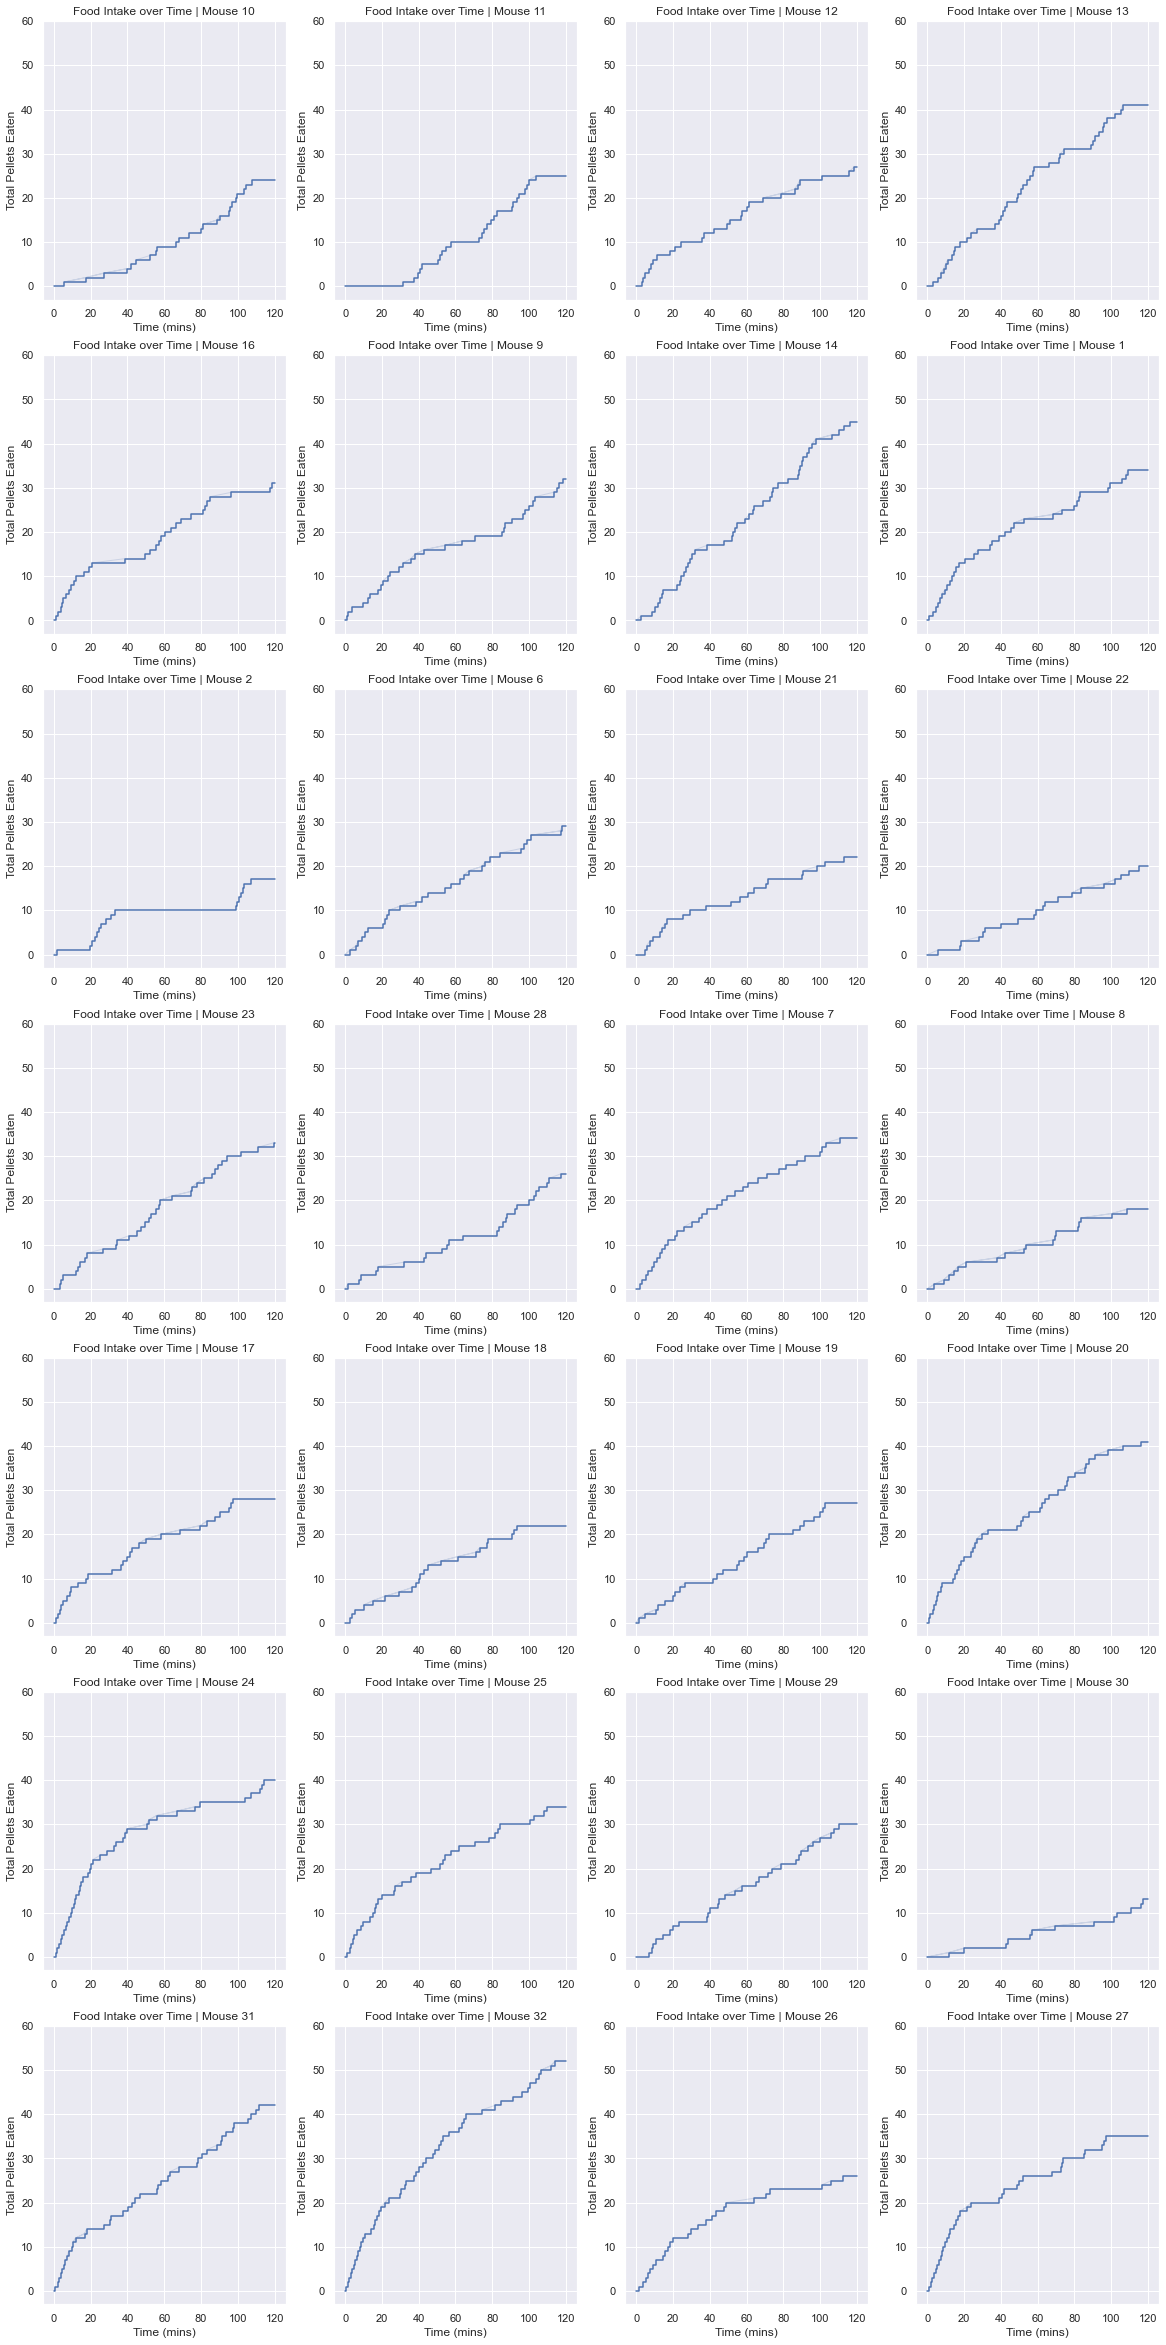

In [21]:
def plot_data_grid(data, mouse_num, ax):
    '''
    Plots and saves a regression plot of the provided dataframe and
    mouse number in a provided subplot.
    '''
    sns.set()
    sns.lineplot(data=data, x='CumulativePelletInterval', y='Pellet_Count',
                 ax=ax, drawstyle='steps-post')
    ax.set_title('Food Intake over Time | Mouse ' + str(mouse_num))
    ax.set_xlabel('Time (mins)')
    ax.set_ylabel('Total Pellets Eaten')
    ax.set_ylim(-3, 60)

# Determine grid size, create grid, and convert axes to iterable list
num_rows = math.ceil((len(filenames_to_mouse_minus_pellet) + len(filenames_to_mouse)) / 4)
fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows*6))
axes_list = axes.ravel()

# Plot each graph sequentially on the grid
for filename, info, ax in zip(filenames_to_mouse.keys(), filenames_to_mouse.values(), axes_list):
    data = load_data(filename)
    data = process_data(data, info[2])
    plot_data_grid(data, info[0], ax)
    data[['Mouse #', 'Cohort']] = [info[0], info[1]]
    master_data = master_data.append(data)

axes_list = axes_list[4:]
for filename, info, ax in zip(filenames_to_mouse_minus_pellet.keys(), filenames_to_mouse_minus_pellet.values(), axes_list):
    data = load_data(filename)
    data = process_data_minus_pellet(data)
    plot_data_grid(data, info[0], ax)
    data[['Mouse #', 'Cohort']] = [info[0], info[1]]
    master_data = master_data.append(data)

plt.savefig('Food Intake Study Data/plots/All Individual Mice Grid.png')
plt.show()

### Overlay all data in the same graph and separate by cohort

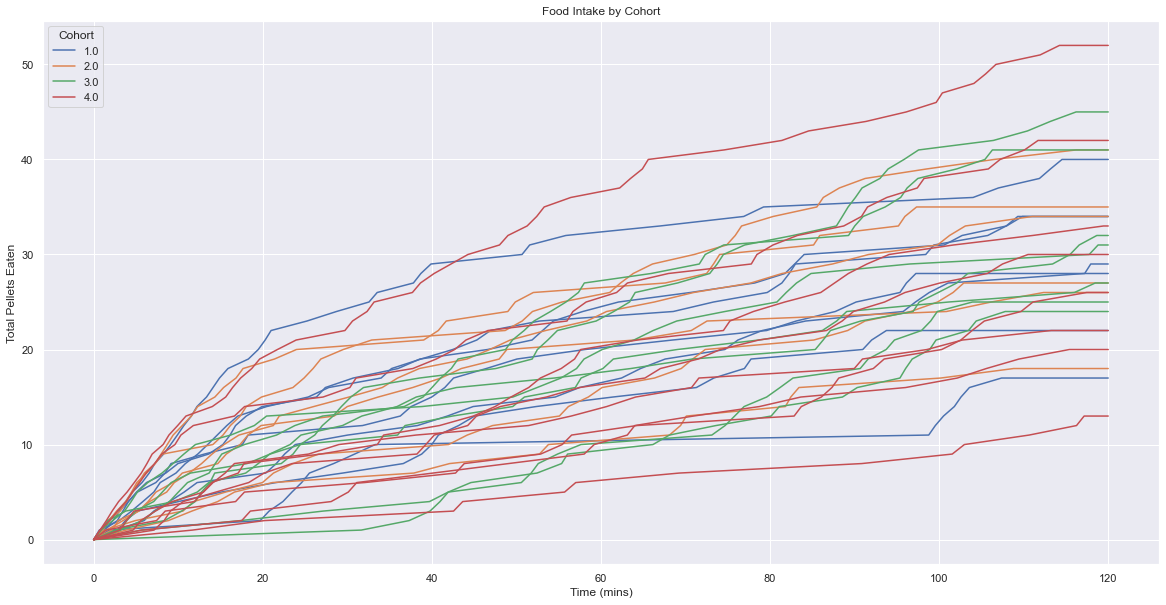

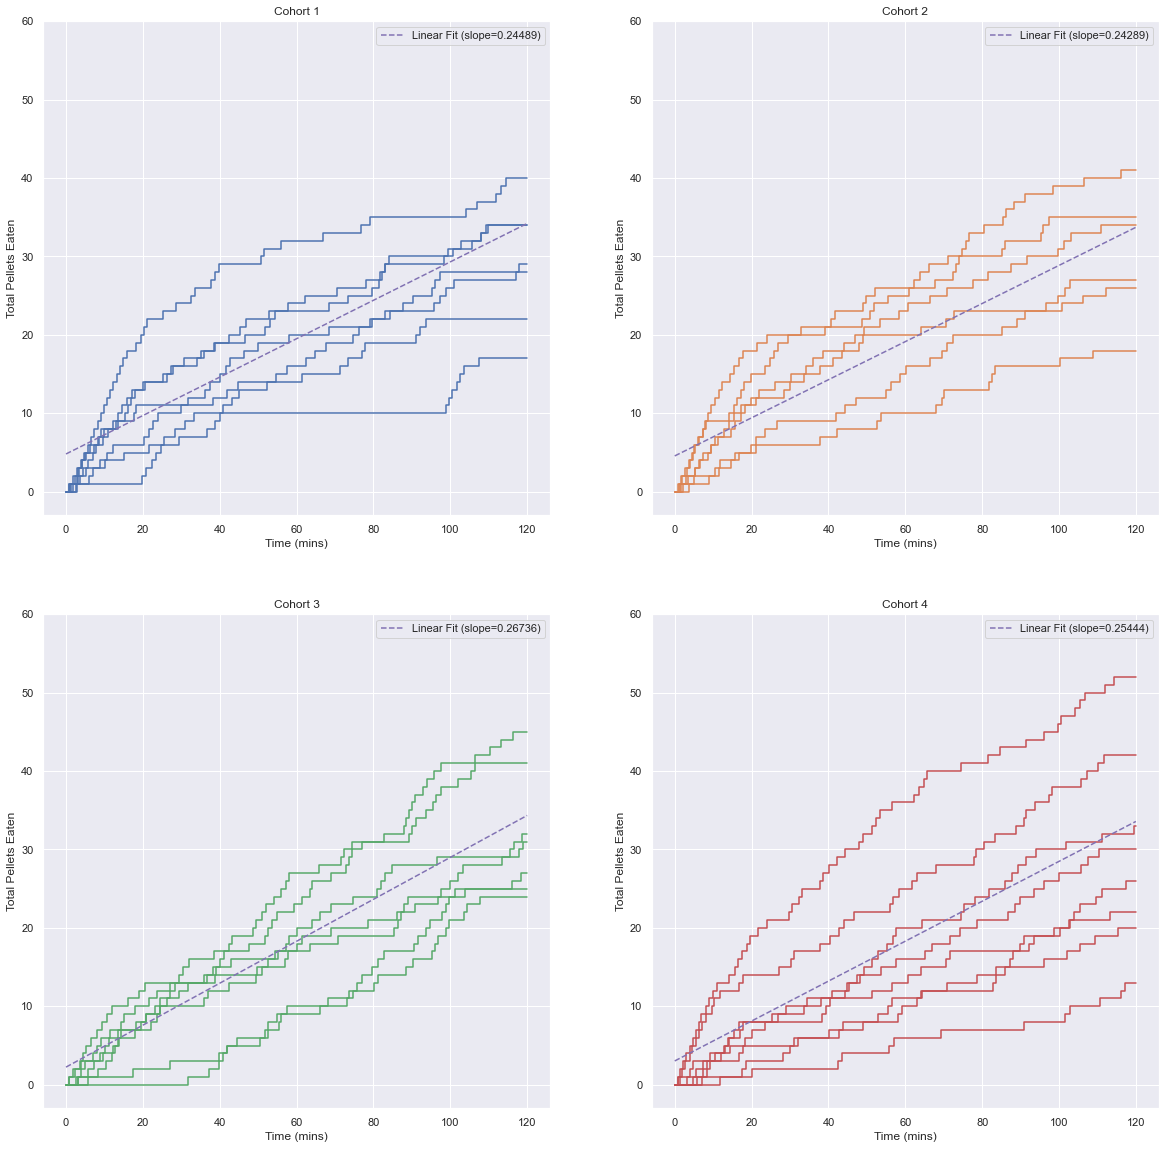

In [25]:
def format_plot(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Time (mins)')
    ax.set_ylabel('Total Pellets Eaten')

def linear(x, m, b):
    return m*x + b

def exponential(x, a, b, c):
    return a*(x**c) + b

# Plot all mice food intake curves on the same graph
master_data = master_data.reset_index(drop=True)
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=master_data, x='CumulativePelletInterval', y='Pellet_Count', ax=ax, hue='Cohort', units='Mouse #', estimator=None, palette='deep')
format_plot(ax, 'Food Intake by Cohort')
plt.savefig('Food Intake Study Data/plots/All Mice.png')
plt.show()

# Plot all mice food intake curves separated by cohort groups 
cohort1_data, cohort2_data, cohort3_data, cohort4_data =\
    master_data[master_data['Cohort'] == 1], master_data[master_data['Cohort'] == 2], master_data[master_data['Cohort'] == 3], master_data[master_data['Cohort'] == 4]
all_cohort_data = {'Cohort 1':cohort1_data, 'Cohort 2':cohort2_data, 'Cohort 3':cohort3_data, 'Cohort 4':cohort4_data}
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for cohort, ax, color in zip(all_cohort_data.items(), axes.ravel(), ['C0', 'C1', 'C2', 'C3']):
    sns.lineplot(data=cohort[1], x='CumulativePelletInterval', y='Pellet_Count', ax=ax, units='Mouse #', estimator=None, color=color, drawstyle='steps-post')
    xrange = np.linspace(0, 120, 100)
    xdata = cohort[1]['CumulativePelletInterval'].to_numpy()
    ydata = cohort[1]['Pellet_Count'].to_numpy()
    params, pcov = curve_fit(linear, xdata, ydata)
    ax.plot(xrange, linear(xrange, *params), '--', color='C4', label='Linear Fit (slope=' + str(round(params[0], 5)) + ')')
    # params2, pcov2 = curve_fit(exponential, xdata, ydata)
    # ax.plot(xrange, exponential(xrange, *params2), '--', color='C5', label='Exponential Fit')
    ax.set_ylim(-3, 60)
    ax.legend()
    format_plot(ax, cohort[0])
plt.savefig('Food Intake Study Data/plots/All Mice Separated by Cohort')
plt.show()

### Create bar graphs of averaged results within each cohort

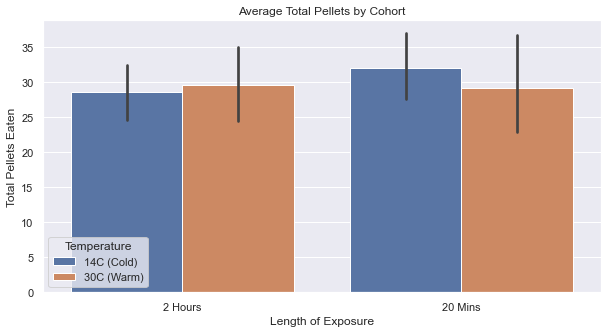

In [23]:
# Create a new dataframe with mice numbers and totals, then join it to the master dataframe to get cohort numbers
fig2, ax = plt.subplots(1, 1, figsize=(10, 5))
total_data = pd.DataFrame()
total_data['Total Pellets Eaten'] = np.array(totals) - np.array(uneaten_pellets)
total_data['Mouse Number'] = mice_nums
merged_df = master_df.merge(total_data, left_on='Mouse #', right_on='Mouse Number', how='outer')

# Add columns to the merged dataframe with the exposure length and temperature
def add_exp_time(num):
    if num == '1' or num == '2':
        return '2 Hours'
    else:
        return '20 Mins'

def add_temp(num):
    if num == '1' or num == '3':
        return '14C (Cold)'
    else:
        return '30C (Warm)'

merged_df['Length of Exposure'] = merged_df['Cohort'].apply(add_exp_time)
merged_df['Temperature'] = merged_df['Cohort'].apply(add_temp)

# Plot results
sns.set()
sns.barplot(data=merged_df, x='Length of Exposure', y='Total Pellets Eaten', hue='Temperature', ci=90)
plt.title('Average Total Pellets by Cohort')
plt.savefig('Food Intake Study Data/plots/Average Food Intake by Cohort')
plt.show()